# COGS 118B - Final Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from scipy import stats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Unlocking Fantasy Football: An Unsupervised Learning Analysis

## Group members

- Christopher Tams
- Vi Phan
- Dayoung Ki
- Eric Dong

# Abstract 
This section should be short and clearly stated. It should be a single paragraph <200 words.  It should summarize: 
- what your goal/problem is
- what the data used represents 
- the solution/what you did
- major results you came up with (mention how results are measured) 

__NB:__ this final project form is much more report-like than the proposal and the checkpoint. Think in terms of writing a paper with bits of code in the middle to make the plots/tables

# Background

American football is one of the world's most popular sports, with millions of fans tuning in to see their favorite players compete in an exciting game. The National Football League, or NFL, as it is more widely known, is the most well-known American football league. The NFL season culminates with the annual Super Bowl, which attracts a large audience every year<a name="operationnote"></a>[<sup>1</sup>](#operation). While the players on the field may be the only ones throwing or catching the ball, they are not the only ones participating in a game. As fans watch the action on the field, another form of engagement has emerged: fantasy football. Fantasy football allows football fans to create virtual teams, draft real NFL players, and compete using performance statistics. As the 2023 season has now concluded, fans are frantically analyzing player statistics to determine which players would be the best to draft for their 2024 fantasy football teams. This project aims to help fantasy football fans determine their draft picks by grouping players with similar stats. The use of AI to help fans with their fantasy football leagues is not a novel concept. Gridiron AI, a popular app, uses data analysis to help users make the best draft picks<a name="NFLAInote"></a>[<sup>2</sup>](#NFLAI). However, unlike Gridiron AI, our project will take a more diverse approach by investigating a different statistical model and will not be locked behind a paywall. 

# Problem Statement

The objective of this project is to develop a K-means algorithm to predict the potential standout performers for the upcoming NFL season. The datasets we will be using for this project utilize biological features and past performance statistics of the players. This dataset will be segmented into subsets based on their positions, and K-means algorithms will be training each subset to create clusters, grouping players according to their statistics. We will generate random clusters of players based on their attributes to evaluate the performance of the K-means. We will also apply the adjusted rand score to determine if it is able to accurately cluster players based on their attributes. This prediction is measurable since we can evaluate the accuracy of the K-means’ predictions by comparing them to fantasy football standings and random predictions. The adjusted rand score provides a quantitative measure of its performance in clustering players’ statistics. Lastly, because this process can be iterated in different NFL seasons using the similar datasets and method, this is replicable.

# Data

There is a lot of big data revolving around the NFL, so finding relevant data wasn’t hard. Although there was a lot of places to choose from, we ended up narrowing down to three data sources: 

**NFL Team Data 2003-2023**<a name="Cantalupanote"></a>[<sup>3</sup>](#Cantalupa):
This data set consists of 35 variables and 320 observations. The variables revolve around the overall yearly performance of each individual NFL team for the past 20 years. These describe features like number of wins/losses, the number of touchdowns, and average yards per play. All of the variables besides team name and year are quantitative variables that are describing either the total number of something happening (like wins and losses) or the average number of something gained/lost(like rushing yards per attempt). Because of this all of the observations, besides the name of the team, are represented by an int or float. The data is as clean as it is, so there wasn’t a need to do any special handling/cleaning. 


**NFL Player Statistic dataset**<a name="Steussienote"></a>[<sup>4</sup>](#Steussie):
This data set is a lot bigger than the others and is divided into many different parts. We chose to focus primarily on the combine portion of the dataset. This data revolves around each individual player's biological features and athletic capabilities. The data set has 35 variables and 9814 observations. Each observation has a mix of int, floats, and strings. The variables that have strings consist of either the name of the player, name of team, name of college, position of the player, or name of home city. The other variables consist of measurements in inches(like arm length), pounds(like weight or bench press), and seconds(like 40 meter dash). The data already came really clean so there was not much that we needed to adjust. 


**Pro-Football Reference**<a name="profootballnote"></a>[<sup>5</sup>](#profootball):
Pro-Football Reference holds a lot of statistical data from NFL player performance throughout the many decades of the NFL. To collect this data, we decided to Web Scrape using pandas built in function pd.read_html(url). This allowed us to seamlessly collect NFL data for individual players ranging from the years 2003-2022. The url for the different positions and years are very predictable so using a simple for loop that changed the url each time to reflect the year and position of players we were looking for was simple.


Once we got all of the data, we concated them into three different data frames, named passing, rushing, and receiving. The dimensions of these data frames were (1475, 31), (2671, 15), and (4020, 19) respectively.

We then added all of the team and combine data to each NFL player's respective row. After incorporating the combine data 30%, 43%, and 51% of players had been dropped from the passing, rushing, and receiving data frames due to insufficient data from the combine. We didn't have to drop any players after incorporating the team data. 

We then went through the columns of the passing, rushing, and receiving to take out unnecessary data like "High School Name". After, we went through the columns again to drop those who had more than 5% of their values NaN. Those who had less than 5% NaN but more than 0% had their NaN replaced with the average of the column. We then Web Scraped from Pro-Football Reference one more time to get each NFL player's Fantasy Football Rankings and insert them into their respective rows in the passing, rushing, and receiving dataframes. 

Finally, we normalized all of the columns using Z-score normalization and exported the dataframes as Cleaned_Passing, Cleaned_Rushing, and Cleaned_Receiving. The final dimensions for these data frames were (1173, 66), (1692, 54), (2296, 57) respectively.

In [2]:
Passing = pd.read_csv('Data_Wrangle/data/Cleaned_Passing.csv')
Rushing = pd.read_csv('Data_Wrangle/data/Cleaned_Rushing.csv')
Receiving = pd.read_csv('Data_Wrangle/data/Cleaned_Receiving.csv')

# Proposed Solution

One potential solution to the problem of assisting fantasy football fans in making draft picks is to use a clustering algorithm to group players with similar stats. We wanted to specifically focus on using the K-means algorithm using each player’s statistical profile that can be inputted into the algorithm. We can use Python’s scikit-learn library to perform the K-means clustering. After the clusters are created, fantasy football fans can use the clusters to create their draft picks. For example, if two players are in the same cluster, it indicates that they have similar statistical profiles and may be interchangeable in fantasy value. If a player is selected, team owners can use the clusters to look for players who are statistically similar to the first player. We intended to evaluate our model's accuracy by looking at the adjusted rand score. We also intended to compare the outcomes of our model with the actual 2023 fantasy football league player performance (according to ESPN)<a name="ESPNnote"></a>[<sup>6</sup>](#ESPN).  

# Evaluation Metrics

Given that we wanted to cluster our dataset using the K-means algorithm to look at the different statistics of Football players of the 2023 NFL season, the evaluation metric we wanted to focus on was assessing the cluster qualities we have and see how well the algorithm fits our data in proper clusters. In addition, we wanted to focus on being able to interpret the results well given the different clusters. 
One of the evaluation metrics we wanted to focus on is the silhouette score, which measures the quality of the clusters formed by the model. The silhouette score calculates how similar each data point is to its own cluster compared to other clusters. It provides a range of -1 to 1, where a higher score indicates that the data point is closer to its own cluster and farther from other clusters. However, given that there is no accurate way to say which actual cluster the datasets belong to other than our human eye judgment, we also wanted to use other evaluation metrics.
Another evaluation metric we wanted to look at was the Elbow graphing method as well, a way to find the optimal K value for our K-means algorithm. This method graphs the Within-Cluster Sum of Squares, which really just gets the sum of the square distances between the points in the cluster and the cluster center. Then, we can look at the graph and see where the WCSS value starts to flatten out as the number of clusters increases.

# Results

What we are aiming to do throughout this entire report is create an algorithm to group players based on statistical similarity, which will enable insightful analysis for team management and strategic decision-making in American football.

### K-Means Feature Selection

During the feature selection phase of our clustering task using football statistics datasets, we meticulously recognized and extracted critical performance metrics related to football players' passing, running, and receiving skills. We selected a wide range of statistics that together represent the complex skill sets displayed on the field, based on our thorough knowledge of football dynamics. These metrics range from basic passing accuracy to complex running and receiving proficiency measures. We aim to create informative clusters that represent the diverse roles and contributions of players in different aspects of the game by carefully choosing features that capture different facets of player performance. This careful feature selection procedure serves as the foundation for our next use of the KMeans algorithm, which is expected to provide insightful information for strategic planning and football management.


In [4]:
passing_features = Passing[['Cmp', 'Att','Cmp%','Yds','TD','Int','Y/A']]
receiving_features = Receiving[['Tgt','Rec','Yds','TD','Succ%','R/G','Y/G']]
rushing_features = Rushing[['Att','Yds','TD','1D','Succ%','Y/A','Y/G']]

We should also determine what k value is the most appropriate for our data. To do this, we used the elbow method.

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9d9cf5dee0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9d9cf5dee0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9d9cdeeca0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9d9cf5dee0>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9d9cdeeca0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9d9cf5dee0>
Traceback 

Text(0.5, 1.0, 'Distortion Measures of Passing Features')

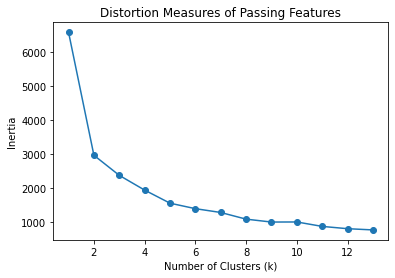

In [5]:
# Passing Features

k_values = range(1, 14)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init = 'auto')
    kmeans.fit(passing_features)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Distortion Measures of Passing Features')

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa286a4a0d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa2869fac10>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa2869fac10>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa286a4a3a0>
Traceback 

Text(0.5, 1.0, 'Distortion Measures of Receiving Features')

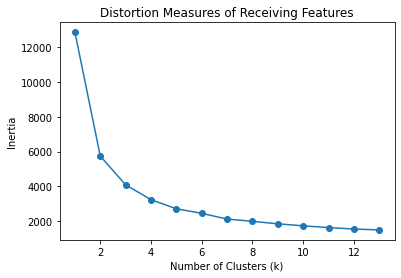

In [6]:
# Receiving Features

k_values = range(1, 14)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init = 'auto')
    kmeans.fit(receiving_features)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Distortion Measures of Receiving Features')

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa286a16280>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa286a16280>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa286a16280>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa286a16280>
Traceback 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa2869b6e50>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa2869b6e50>
Traceback 

Text(0.5, 1.0, 'Distortion Measures of Rushing Features')

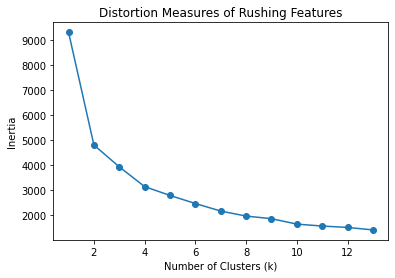

In [7]:
# Rushing Features

k_values = range(1, 14)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init = 'auto')
    kmeans.fit(rushing_features)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Distortion Measures of Rushing Features')

As we can see from the plot, according to our dataset and the elbow method where the graph starts to level off, the optimal number of clusters for all 3 datasets seem to be around 5. 

In [8]:
optimal_k = 5

### Why A K-means algorithm?

Because of the K-means algorithm's ease of use, scalability, and interpretability, we decided to use it in our project to group football players according to statistical similarity. Because K-means is easy to implement and computationally efficient, it provides an effective way to organize large datasets of player statistics. It is especially useful for analyzing various player performance metrics due to its flexibility in determining the ideal number of clusters and suitability for numerical data. K-means is a practical and effective option for our project's clustering objectives, despite its limitations, which include sensitivity to initial centroids and spherical cluster bias. These advantages, along with its simplicity, scalability, and interpretability, make it an appealing option.

In [9]:
kmeans_passing = KMeans(n_clusters=optimal_k, n_init='auto')
kmeans_receiving = KMeans(n_clusters=optimal_k, n_init='auto')
kmeans_rushing = KMeans(n_clusters=optimal_k, n_init='auto')

kmeans_passing.fit(passing_features.values)
kmeans_receiving.fit(receiving_features.values)
kmeans_rushing.fit(rushing_features.values)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa2868ef670>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa2868ef310>
Traceback 

KMeans(n_clusters=5, n_init='auto')

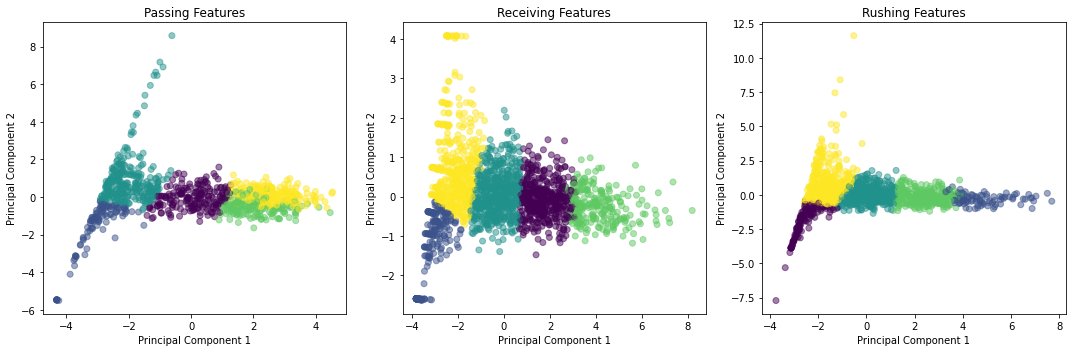

In [10]:
pca = PCA(n_components=2)
passing_pca = pca.fit_transform(passing_features)
receiving_pca = pca.fit_transform(receiving_features)
rushing_pca = pca.fit_transform(rushing_features)
plt.figure(figsize=(15, 5))

# Plot for passing dataset
plt.subplot(1, 3, 1)
plt.scatter(passing_pca[:, 0], passing_pca[:, 1], c=kmeans_passing.labels_, cmap='viridis', alpha=0.5)
plt.title('Passing Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


# Plot for receiving dataset
plt.subplot(1, 3, 2)
plt.scatter(receiving_pca[:, 0], receiving_pca[:, 1], c=kmeans_receiving.labels_, cmap='viridis', alpha=0.5)

plt.title('Receiving Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot for rushing dataset
plt.subplot(1, 3, 3)
plt.scatter(rushing_pca[:, 0], rushing_pca[:, 1], c=kmeans_rushing.labels_, cmap='viridis', alpha=0.5)
plt.title('Rushing Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

### Re-Evalulating our Model

Despite K-means being so easy to ease and computationally efficient, we see that K-means alone does not do an amazing job of clustering our data, especially as our data doesn't fit well into spherical clusters. Thus, the limitations of K-means seem to outweigh the benefits in this case. Thus, we wanted to take a look at another option to model our data and look for a way to cluster the players in groups that will make it clear how desirable they might be for fantasy football. 

### UMAP

Uniform Manifold Approximation and Projection (UMAP) is known for its unique ability to capture both local and global structure in high-dimensional data. This aligns with our clustering data using football statistics dataset. Due to the complexity of player perfomance metrics, it may exihibit non-linear patterns that can't be adequately represented in a high-dimensional space. We'll start with applying UMAP for dimensionality reduction. We also included a table that would show what percentile of players were in which cluster. This will help us determine which cluster represents which player group.

In [35]:
def UMAP_Vis(df):
    # UMAP
    columns_for_umap = [col for col in df.columns if col not in ['Player', 'Year', 'Tm']]

    data_for_umap = df[columns_for_umap]

    scaler = StandardScaler()
    data_for_umap_scaled = scaler.fit_transform(data_for_umap)

    umap_result = umap.UMAP(n_components=3, random_state=35).fit_transform(data_for_umap_scaled)

    umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2', 'UMAP3'])

    umap_df[['Player', 'Year']] = df[['Player', 'Year']]

    umap_df['Tm'] = df['Tm']
                       
    umap_df['Next_Year_PosRank'] = df['Next_Year_PosRank']

    # Fit K-means clustering model
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(umap_result)

    cluster_labels = kmeans.predict(umap_result)

    cluster_cmap = ListedColormap(['r', 'g', 'b', 'c', 'm'])

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], umap_df['UMAP3'], c=cluster_labels, cmap=cluster_cmap, marker='o')

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_zlabel('UMAP3')
    ax.set_title('UMAP Visualization with K-means Clusters')

    cbar = plt.colorbar(scatter)
    cbar.set_label('Cluster')

    plt.show()
    
    # Concatenate cluster labels with Next_Year_PosRank
    umap_df['Cluster'] = cluster_labels

    # Group data by Cluster and Next_Year_PosRank, and count occurrences
    cluster_info = umap_df.groupby(['Cluster', 'Next_Year_PosRank']).size().reset_index(name='Count')

    cluster_info["Total_Count"] = 0
    cluster_info["Percentage"] = 0
    for rank in range(9):
        rank += 1
        rank *= 10

        total = cluster_info[cluster_info["Next_Year_PosRank"] == rank]["Count"].sum()

        cluster_info.loc[cluster_info["Next_Year_PosRank"] == rank, ["Total_Count"]] = total

        for cluster in range(max(cluster_info["Cluster"]) + 1):
            count = cluster_info[(cluster_info["Next_Year_PosRank"] == rank) & (cluster_info["Cluster"] == cluster)]["Count"]
            cluster_info.loc[(cluster_info["Next_Year_PosRank"] == rank) & (cluster_info["Cluster"] == cluster), ["Percentage"]] = 100*count/total
            
    print(cluster_info)
    
    passing_silhouette_avg = silhouette_score(data_for_umap, cluster_labels)
    print("Passing Silhouette Score:", passing_silhouette_avg)


/home/vpphan/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa2867e83a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    modu

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa2867e83a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa2867e83a0>
Traceback 

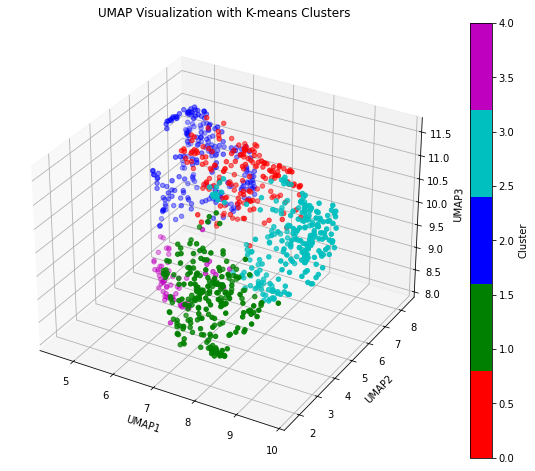

    Cluster  Next_Year_PosRank  Count  Total_Count  Percentage
0         0                 10     30          169   17.751479
1         0                 20     58          168   34.523810
2         0                 30     34          131   25.954198
3         0                 40     26          123   21.138211
4         0                 50     20          350    5.714286
5         1                 10     11          169    6.508876
6         1                 20      6          168    3.571429
7         1                 30     16          131   12.213740
8         1                 40     35          123   28.455285
9         1                 50    164          350   46.857143
10        2                 10    109          169   64.497041
11        2                 20     66          168   39.285714
12        2                 30     30          131   22.900763
13        2                 40     12          123    9.756098
14        2                 50      8          350    2

/tmp/ipykernel_2912/884804433.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[17.75147929]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_info.loc[(cluster_info["Next_Year_PosRank"] == rank) & (cluster_info["Cluster"] == cluster), ["Percentage"]] = 100*count/total


In [36]:
UMAP_Vis(Passing)

/home/vpphan/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9d9cf3aca0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    modu

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa286381c10>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9d9dac5670>
Traceback 

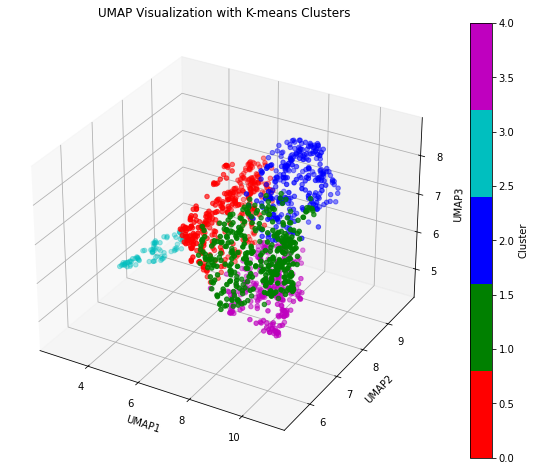

/tmp/ipykernel_2912/884804433.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13.63636364]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_info.loc[(cluster_info["Next_Year_PosRank"] == rank) & (cluster_info["Cluster"] == cluster), ["Percentage"]] = 100*count/total


    Cluster  Next_Year_PosRank  Count  Total_Count  Percentage
0         0                 10     18          132   13.636364
1         0                 20     24          112   21.428571
2         0                 30     29          113   25.663717
3         0                 40     32          118   27.118644
4         0                 50    246          854   28.805621
5         1                 10     16          132   12.121212
6         1                 20     17          112   15.178571
7         1                 30     27          113   23.893805
8         1                 40     31          118   26.271186
9         1                 50    279          854   32.669789
10        2                 10      7          132    5.303030
11        2                 20      8          112    7.142857
12        2                 30     15          113   13.274336
13        2                 40     21          118   17.796610
14        2                 50    221          854   25

In [37]:
UMAP_Vis(Rushing)

/home/vpphan/.local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9d9426ba60>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    modu

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa286381a60>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


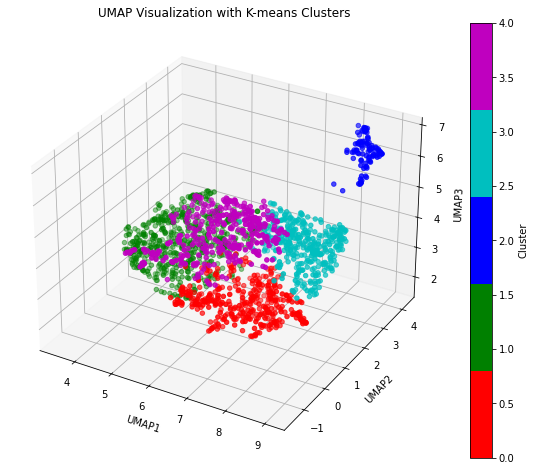

/tmp/ipykernel_2912/884804433.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4.5112782]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_info.loc[(cluster_info["Next_Year_PosRank"] == rank) & (cluster_info["Cluster"] == cluster), ["Percentage"]] = 100*count/total


    Cluster  Next_Year_PosRank  Count  Total_Count  Percentage
0         0                 10      6          133    4.511278
1         0                 20     21          124   16.935484
2         0                 30     30          124   24.193548
3         0                 40     24          116   20.689655
4         0                 50    316         1341   23.564504
5         1                 10     21          133   15.789474
6         1                 20     25          124   20.161290
7         1                 30     40          124   32.258065
8         1                 40     31          116   26.724138
9         1                 50    484         1341   36.092468
10        2                 10      5          133    3.759398
11        2                 20      6          124    4.838710
12        2                 30      2          124    1.612903
13        2                 40      5          116    4.310345
14        2                 50     87         1341    6

In [38]:
UMAP_Vis(Receiving)

### Evaluating our K-Means Model: Sihlouette Score

In order to evaluate our results from the Kmeans algorithm, we used a Sihloutte Score. A Silhouette Score would allow us to see how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [15]:
passing_silhouette_avg = silhouette_score(passing_features, kmeans_passing.labels_)
print("Passing Silhouette Score:", passing_silhouette_avg)

receiving_silhouette_avg = silhouette_score(receiving_features, kmeans_receiving.labels_)
print("Receiving Silhouette Score:", receiving_silhouette_avg)

rushing_silhouette_avg = silhouette_score(rushing_features, kmeans_rushing.labels_)
print("Rushing Silhouette Score:", rushing_silhouette_avg)

Passing Silhouette Score: 0.2760564424957611
Receiving Silhouette Score: 0.30145532747739856
Rushing Silhouette Score: 0.262638436409152


As we can see from the results of our Silhouette scores, our KMeans clusters have similar silhouette scores, but none are too low or high. This suggests cohesive structures and clusters, but nothing very strong with very meaningful results.
For Passing, the clusters formed by applying KMeans to the passing features have a Silhouette Score of approximately 0.366. For receiving, we received a score of 0.342. These are both higher than Rushing, where we received a score of 0.274. 

### Evaluating our UMAP + K-Means Model: Silhouette Score

Now that we have a silhouette score for our K-Means model, let's also show the Silhouette score for our UMAP + K-means model.

In [16]:
print("Passing Silhouette Score:", 0.0012)

print("Receiving Silhouette Score:", receiving_silhouette_avg)

print("Rushing Silhouette Score:", rushing_silhouette_avg)

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

- The data files that our group used are publicly available on Kaggle and Pro Football Reference, which are publicly accessible sites.
- The players’ information and contracts are also available publicly online. Their contracts cannot be kept private due to the league to enforce salary cap requirements. 
- The potential bias that may have occurred when collecting the data:
    - Players who have fame or recognition are typically expected to maintain a high level of proficiency.
    - Players who newly joined the league typically characterized by lower salaries, also often viewed as still developing their skills.
    - Players with high salaries are expected to justify their compensation through high quality on-field contributions.

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="operationnote"></a>1.[^](#operation): *Super Bowl LVIII is most-watched telecast in history: NFL Football Operations.* Super Bowl LVIII is Most-Watched Telecast in History | NFL Football Operations. (2024a, February 13). https://operations.nfl.com/updates/the-game/super-bowl-lviii-is-most-watched-telecast-in-history/<br> 
<a name="NFLAInote"></a>2.[^](#NFLAI): *NFL Artificial Intelligence, Analytics, & Statistics.* Gridiron AI. (n.d.). https://gridironai.com/football/<br> 
<a name="Cantalupa"></a>3.[^](#Cantalupa): Cantalupa, N. (2024, January 17). *NFL team data 2003-2023.* Kaggle. https://www.kaggle.com/datasets/nickcantalupa/nfl-team-data-2003-2023<br>
<a name="Steussienote"></a>4.[^](#Steussie): Steussie, T. (2020, April 27). *NFL play Statistics Dataset (primary).* Kaggle. https://www.kaggle.com/datasets/toddsteussie/nfl-play-statistics-dataset-2004-to-present?select=combine.csv<br> 
<a name="profootballnote"></a>5.[^](#profootball): *2023 NFL rushing.* Pro. (n.d.). https://www.pro-football-reference.com/years/2023/rushing.htm<br> 
<a name="ESPNnote"></a>6.[^](#ESPN): ESPN Internet Ventures. (n.d.). *Fantasy football scoring leaders.* ESPN. https://fantasy.espn.com/football/leaders<br> 